In [ ]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from Auxiliary.helper import *
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
res = pd.read_csv('/data/fields/Auxiliary/grid_search/256_20_masked_chipsvrt_GSA-DE_BRB-2019_All_agromask_linecrop_prediction_extent_IoU_hyperparameter_tuning_full.csv')
res[res['field_sizes'] == 1]['IoU']

# Assuming 'res' is your DataFrame
# For visualization, you can create a combined column for 't_ext' and 't_bound'
res['t_ext_t_bound'] = res['t_ext'].astype(str) + ' - ' + res['t_bound'].astype(str)

# Create a boxplot
plt.figure(figsize=(10, 6))  # Set figure size
res['field_sizes'] = res['field_sizes'] / 100
print(res['field_sizes'])
sns.boxplot(data=res, x='t_ext_t_bound', y='field_sizes')

# Add labels and title
plt.title('Field Sizes Distribution per t_ext and t_bound')
plt.xlabel('t_ext - t_bound')
plt.ylabel('Field Size in ha')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 10) 
# Show the plot
plt.show()


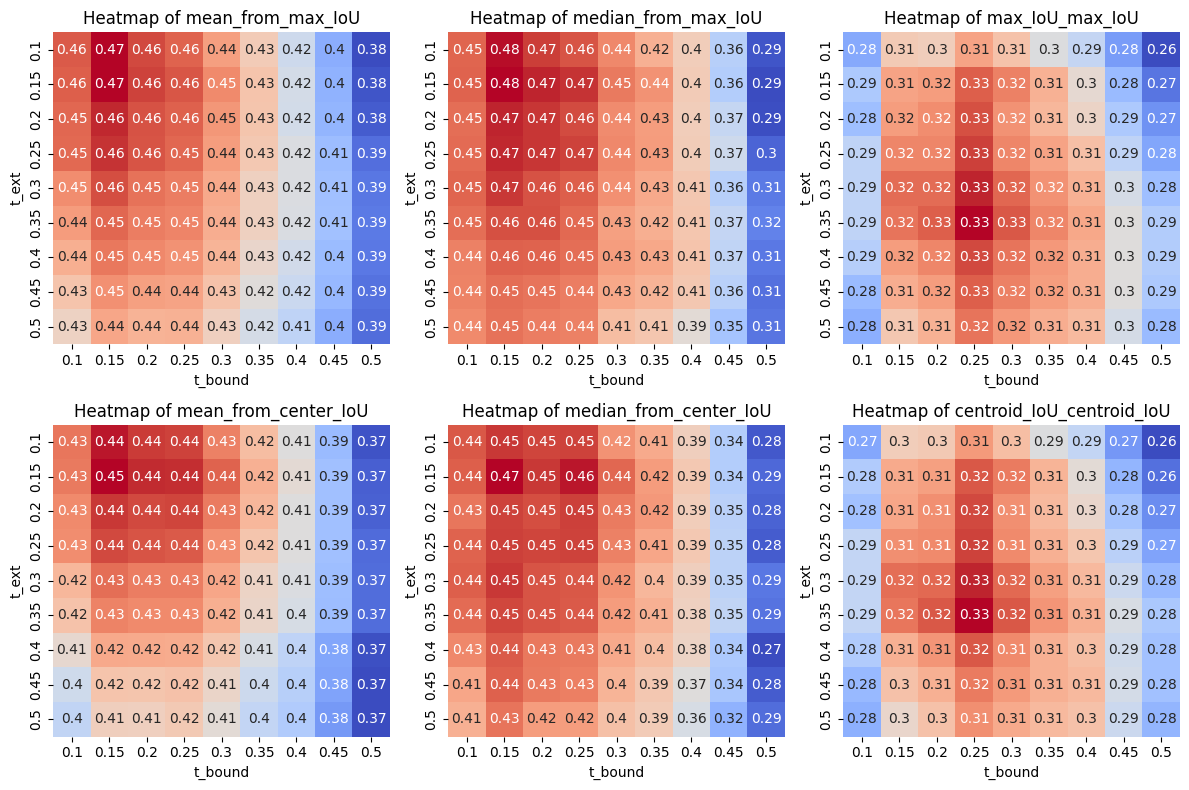

In [50]:
files = getFilelist('/data/fields/Auxiliary/grid_search/Brandenburg/', '.csv')
res = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

filtered_df = res[res['reference_field_sizes'] > 10]

# Scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(filtered_df['reference_field_sizes'], filtered_df['max_IoU'], color='b', marker='o')
# plt.xlabel('Field size')
# plt.ylabel('Max IoU')
# plt.grid(True)
# plt.show()


# # Group by 't_ext' and 't_bound' and calculate the mean and median of IoU
grouped_stats = filtered_df.groupby(['t_ext', 't_bound']).agg({'max_IoU': ['mean', 'median'],
                                                              'centroid_IoU': ['mean', 'median']}).reset_index()
grouped_stats.columns = ['t_ext', 't_bound', 'mean_from_max_IoU', 'median_from_max_IoU', 
                         'mean_from_center_IoU', 'median_from_center_IoU']
# Count IoU values greater than 0.5 and 0.8 and divide by the total count per group
# Define function to calculate IoU ratios (return numeric values)
def calculate_ratios(x):
    ratio_05 = (x > 0.5).sum() / len(x)
    ratio_08 = (x > 0.8).sum() / len(x)
    return pd.Series({'IoU_50': ratio_05, 'IoU_80': ratio_08})

# Columns you want to apply the function to
cols = ['max_IoU', 'centroid_IoU']
conti = []

# Loop over the columns and apply the ratios function
for col in cols:
    # Group by t_ext and t_bound, apply the ratio calculation function
    sub = filtered_df.groupby(['t_ext', 't_bound'])[col].apply(calculate_ratios).reset_index()
    
    # Add a 'metric' column to track which column we are working with
    sub['metric'] = col
    
    # Melt the DataFrame to turn IoU_50 and IoU_80 into 'level_2'
    sub = sub.melt(id_vars=["t_ext", "t_bound", "metric"], var_name="level_2", value_name="value")
    
    # Append the result to a list of DataFrames
    conti.append(sub)

# Concatenate the list of DataFrames into one
combined = pd.concat(conti)

# Ensure that the 'value' column is numeric (it should be from the ratios)
combined['value'] = pd.to_numeric(combined['value'], errors='coerce')

# Drop any rows with NaN values in 'value' (if there were any conversion issues)
combined = combined.dropna(subset=["value"])

# Now aggregate the values (mean) for each combination of t_ext, t_bound, metric, and level_2
combined_agg = combined.groupby(['t_ext', 't_bound', 'metric', 'level_2']).agg({'value': 'mean'}).reset_index()

# Pivot the DataFrame to create separate columns for IoU_50 and IoU_80 for each metric
ratios_pivoted = combined_agg.pivot(index=['t_ext', 't_bound'], columns=['metric', 'level_2'], values='value')

# Flatten the MultiIndex columns (e.g., ('max_IoU', 'IoU_50') -> 'max_IoU_IoU_50')
ratios_pivoted.columns = [f"{metric}_{level}" for metric, level in ratios_pivoted.columns]

# Reset index for a flat DataFrame
ratios_pivoted = ratios_pivoted.reset_index()
# merge grouped_stats with the 2 calculated columns
merged_df = pd.merge(grouped_stats, ratios_pivoted, on=['t_ext', 't_bound'])


# Assuming merged_df contains the data as described
columns_to_plot = [
    'mean_from_max_IoU', 'median_from_max_IoU', 'max_IoU_max_IoU',
    'mean_from_center_IoU', 'median_from_center_IoU', 'centroid_IoU_centroid_IoU'
]

# Set up a matplotlib figure for the heatmap layout
plt.figure(figsize=(12, 8))

# Iterate over the columns and create a heatmap for each
for i, column in enumerate(columns_to_plot, start=1):
    # Pivot the DataFrame for the heatmap
    heatmap_data = merged_df.pivot(index='t_ext', columns='t_bound', values=column)

    # Plot the heatmap
    plt.subplot(2, 3, i)  # Adjust the layout for a 2x3 grid
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar=False)#cbar_kws={'label': column})
    
    # Title for each heatmap
    plt.title(f'Heatmap of {column}')
    plt.xlabel('t_bound')
    plt.ylabel('t_ext')

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

In [45]:
merged_df

,t_ext,t_bound,mean_from_max_IoU,median_from_max_IoU,mean_from_max_IoU_2,median_from_max_IoU_2,centroid_IoU_centroid_IoU,max_IoU_max_IoU
0,0.1,0.10,0.340930,0.328139,0.323494,0.281791,0.190160,0.191489
1,0.1,0.15,0.347219,0.333333,0.331583,0.296587,0.207447,0.211436
2,0.1,0.20,0.338666,0.309323,0.325305,0.237772,0.207447,0.210106
3,0.1,0.25,0.333393,0.273687,0.322306,0.203537,0.214096,0.218085
4,0.1,0.30,0.319498,0.200610,0.309328,0.182355,0.204787,0.208777
...,...,...,...,...,...,...,...,...
76,0.5,0.30,0.303019,0.155550,0.287371,0.107153,0.214096,0.218085
77,0.5,0.35,0.296701,0.134880,0.279978,0.081453,0.211436,0.218085
78,0.5,0.40,0.290582,0.118241,0.275409,0.072075,0.207447,0.212766
79,0.5,0.45,0.273539,0.104150,0.258392,0.058783,0.187500,0.192819


In [ ]:
# # Plot the heatmap
# # Pivot the dataframe to create a matrix for the heatmap
# heatmap_data = res.pivot(index='t_ext', columns='t_bound', values='mean_IoU')

# # Plot the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(heatmap_data, annot=True, cmap='viridis')
# plt.title('Mean IoU Heatmap')
# plt.xlabel('t_bound')
# plt.ylabel('t_ext')
# plt.gca().invert_yaxis()
# plt.show()

# # Scatter plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='t_ext', y='t_bound', size='mean_IoU', data=res, hue='mean_IoU', palette='viridis', sizes=(50, 200))
# plt.title('Scatter Plot of Mean IoU')
# plt.xlabel('t_ext')
# plt.ylabel('t_bound')
# plt.show()